In [109]:
import numpy as np
from scipy.stats import laplace
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import cm
from matplotlib import colors

%matplotlib inline

In [3]:
from Master_Functions import CondExtBivNegLogLik
from DeltaLaplaceFuncs import DeltaLaplace

In [4]:
# For module development

%load_ext autoreload
%autoreload 2

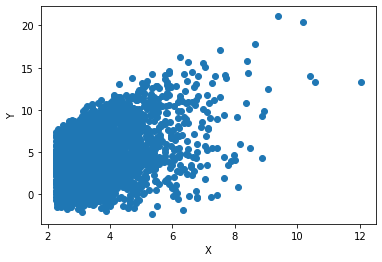

In [145]:
# Create toy data. We require X to be Laplace. 
X = laplace(0,1).rvs(100000)

#We'll also let Z be Delta_Laplace noise

#Condition on X being larger than some high quantile u

u = np.quantile(X,0.95)
X = X[X>u]
Z = DeltaLaplace(loc =1,scale = 1,shape = 4).rvs(size=len(X), random_state =2)

Y = 0.5 * X + Z*(X**0.8)


fig=plt.figure()
plt.scatter(X,Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [146]:
## Fit distribution. We will use Delta-Laplace margins.

init_par=[0.5,0.2,0.2,0.5,2]

X_data, Y_data = X,Y

use_DL = True

fit = minimize(fun = CondExtBivNegLogLik,x0 = init_par,
               args=(X_data,Y_data,use_DL),
               method="Nelder-Mead")

fit

 final_simplex: (array([[0.96439308, 0.73839574, 0.40377857, 1.15455944, 1.29356455],
       [0.96439418, 0.73839546, 0.40375151, 1.15458473, 1.29350043],
       [0.96439128, 0.73842148, 0.40381816, 1.15453365, 1.2935098 ],
       [0.96439398, 0.73840023, 0.40375733, 1.15457905, 1.29347433],
       [0.96439251, 0.73840458, 0.40378129, 1.15457367, 1.29358734],
       [0.96439256, 0.73839388, 0.40380705, 1.15451125, 1.29353578]]), array([17022.09048831, 17022.09048911, 17022.09048938, 17022.09049116,
       17022.09049426, 17022.09049445]))
           fun: 17022.09048831283
       message: 'Optimization terminated successfully.'
          nfev: 679
           nit: 406
        status: 0
       success: True
             x: array([0.96439308, 0.73839574, 0.40377857, 1.15455944, 1.29356455])

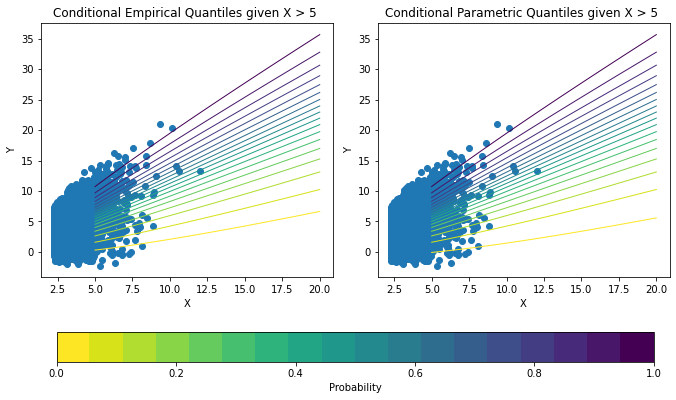

In [157]:
# Overlay conditional quantiles, given X > u, on Scatter plot
alpha,beta,mu,sigma,delta = fit.x

u=5

x_seq=np.linspace(u,20,100)
probs=np.arange(0.05,0.95,0.05)
cmap = plt.get_cmap('viridis_r', len(probs))

#Using empirical quantiles (LEFT)

quants = np.quantile(z_hat, probs)

fig , axs = plt.subplots(1,2, figsize=(9.5, 6))
axs[0].scatter(X,Y)
axs[1].scatter(X,Y)

axs[0].set(xlabel="X", ylabel="Y")
axs[1].set(xlabel="X", ylabel="Y")

axs[0].set_title("Conditional Empirical Quantiles given X > %u " %u)
axs[1].set_title("Conditional Parametric Quantiles given X > %u " %u)

  #Using empirical quantiles (LEFT)
z_hat = (Y[ X >u] - alpha * X[X > u])/ X[X > u]** beta

quants = np.quantile(z_hat, probs)

for k in range(0,len(probs)):
    
    axs[0].plot(x_seq,alpha*x_seq+quants[k]*x_seq**beta,color = viridis.colors[(k)], linewidth = 1)
    #Using empirical quantiles (Right)
    
    quants = DeltaLaplace(loc = mu, scale = sigma, shape = delta).ppf(probs)

for k in range(0,len(probs)):
    
    axs[1].plot(x_seq,alpha*x_seq+quants[k]*x_seq**beta,color = viridis.colors[(k)], linewidth = 1)


fig.subplots_adjust(right=1)

# creating ScalarMappable 
norm = colors.Normalize(vmin=0.,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap,norm = norm) 
sm.set_array([]) 
plt.tight_layout()
fig.colorbar(sm, label = "Probability", orientation = "horizontal",ax =axs.ravel().tolist(), shrink=0.95)
plt.show()